# Crash Predictive ML Model

We will create a model to predict the number of crashes using the following:
- weather (temp, snow, rain, precip)
- day of week (Mon, Tues...)
- intersection characteristics
- violations
- red light cam presence
- congestion
- covid cases


In this model, we will use all available data: hourly, daily, and intersection characteristics.  This dataset will be be over a million lines wi

In [63]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly_express as px
import plotly

import warnings
warnings.filterwarnings('ignore')


# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from modules.myfuncs import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from boruta import BorutaPy

import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Decision Tree
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

from datetime import datetime



SyntaxError: invalid syntax (<ipython-input-63-2e8af1afad6d>, line 52)

In [2]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db



We will try to get data that is daily for all of the above info.  

In [3]:
print(sql_fetch_tables(c, conn))



def table_info(c, conn):
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    for table_name in tables:
        table_name = table_name[0]
        table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), conn)
        print(table_name)
        for col in table.columns:
            print('\t' + col)
        print()

table_info(c, conn)


[('cam_locations',), ('cam_startend',), ('daily_violations',), ('all_crashes',), ('hourly_congestion',), ('hourly_weather',), ('region_data',), ('intersection_cams',), ('int_startend',), ('intersection_chars',), ('signal_crashes',), ('all_days',), ('daily_covid',), ('all_hours',)]
cam_locations
	camera_id
	intersection
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

cam_startend
	camera_id
	start
	end

daily_violations
	intersection
	camera_id
	address
	violation_date
	violations
	latitude
	longitude
	month
	day
	weekday
	year

all_crashes
	crash_record_id
	rd_no
	crash_date
	posted_speed_limit
	traffic_control_device
	device_condition
	weather_condition
	lighting_condition
	first_crash_type
	trafficway_type
	alignment
	roadway_surface_cond
	road_defect
	report_type
	crash_type
	damage
	prim_contributory_cause
	sec_contributory_cause
	street_no
	street_direction
	street_name
	beat_of_occurrence
	num_units
	most_severe_injury
	injuries_total
	injuri

## Query our data
I would like to get hourly intersection data with the following columns:


signal_crashes
	-crash_date
	-posted_speed_limit
	-device_condition
	-weather_condition
	-lighting_condition
	-first_crash_type
	-trafficway_type
	-alignment
	-roadway_surface_cond
	-road_defect
	-report_type
	-crash_type
	-damage
	-prim_contributory_cause
	-sec_contributory_cause
	-street_no
	-street_direction
	-street_name
	-most_severe_injury
	-injuries_total
	-injuries_fatal
	-injuries_incapacitating
	-injuries_non_incapacitating
	-injuries_reported_not_evident
	-injuries_no_indication
	-injuries_unknown
	-latitude
	-longitude
	-lane_cnt
	-work_zone_i
	-work_zone_type
	-workers_present_i
	-intersection
	-year
	-month
	-day
	-hour
	-region_id
	-time
	-weekday

hourly_weather
	-temp
	-rain_1h
	-rain_3h
	-snow_1h
	-snow_3h
	-time
	-year
	-month
	-day
	-hour
	-weekday

hourly_congestion
	-year
	-month
	-day
	-hour
	-region_id
	-bus_count
	-num_reads
	-speed
	-weekday
    
Tables will be queried to JOIN on year, month, day, hour

WHAT I REALLY NEED HERE
A single dataset with the following:
- daily intersection chars (all the stuff I entered)
- daily intersection crashes (injuries, deaths, number etc)
- daily wx (temp, precip mainly)
- daily congestion (might not need this)
- daily violations (already in the format)

In [4]:
# Approximately how many entries should I expect to be looking at after filtering my data
# 3 years, 4 months x 153 intersections
print((365.25*3 + 30*4) *153)


186009.75


## Query my db to get a DataFrame with crashes and intersection


In [5]:
# This one groups by day for the whole city

big_df = pd.read_sql_query('''
WITH ah AS(SELECT year,
                month,
                day,
                hour,
                datetime,
                intersection
                
        FROM all_hours
        ),   


    ich AS(SELECT intersection,
                protected_turn,
                total_lanes,
                medians,
                exit,
                split,
                way,
                underpass,
                no_left,
                angled,
                triangle,
                one_way,
                turn_lanes,
                lat,
                long,
                rlc,
                daily_traffic,
                speed
            FROM intersection_chars
        ),


    v AS(SELECT year,
                month,
                day,
                intersection,
                violations
            FROM daily_violations
            GROUP by year, month, day, intersection
        ),

    wx AS(SELECT SUM(snow_1h + rain_1h) AS precip_1h,
                SUM(snow_1h) as snow_1h,
                SUM(rain_1h) as rain_1h,
                MAX(temp) as temp_1h,
                year,
                month,
                day,
                hour
            FROM hourly_weather
            GROUP BY year, month, day, hour
        ),
    
    wxd AS(SELECT SUM(snow_1h + rain_1h) AS precip_daily,
                SUM(snow_1h) as snow_daily,
                SUM(rain_1h) as rain_daily,
                MAX(temp) as temp_daily,
                year,
                month,
                day
            FROM hourly_weather
            GROUP BY year, month, day
        ),

    cr AS(SELECT SUM(injuries_total) AS injuries,
                year,
                month,
                day,
                hour,
                intersection,
                COUNT(DISTINCT crash_record_id) AS n_crash,
                SUM(COALESCE(injuries_total,0)) AS injuries,
                SUM(injuries_fatal) AS injuries_fatal,
                SUM(injuries_incapacitating) AS injuries_incapacitating
         FROM signal_crashes
         GROUP BY year, month, day, hour, intersection
        ),
        
    cov AS(SELECT strftime('%m',lab_report_date) AS month,
            strftime('%Y',lab_report_date) AS year,
            strftime('%d',lab_report_date) AS day,
            lab_report_date,
            cases_total as covid_cases
        FROM daily_covid as dc
        GROUP BY year, month, day
        ),
        
    cg AS(SELECT year,
                month,
                day,
                hour,
                region_id,
                (100-AVG(quantile_speed))/100 as congestion

        FROM hourly_congestion
        GROUP BY year, month, day, hour, region_id),
    
    ic AS(SELECT intersection,
                region_id
            FROM intersection_cams
            )
        

    SELECT 
        ah.year,
        ah.month,
        ah.day,
        ah.hour,
        ah.intersection,
        ah.datetime,
        v.violations,

        wx.snow_1h,
        wx.rain_1h,
        wx.precip_1h,
        wx.temp_1h,
        
        wxd.snow_daily,
        wxd.rain_daily,
        wxd.precip_daily,
        wxd.temp_daily,

        cr.n_crash,
        cr.injuries,
        cr.injuries_fatal,
        cr.injuries_incapacitating,
        
        ich.protected_turn,
        ich.total_lanes,
        ich.medians,
        ich.exit,
        ich.split,
        ich.way,
        ich.underpass,
        ich.no_left,
        ich.angled,
        ich.triangle,
        ich.one_way,
        ich.turn_lanes,
        ich.lat,
        ich.long,
        ich.rlc,
        ich.daily_traffic,
        ich.speed as speed_limit,
        
        cov.covid_cases,
        
        ic.region_id,
        
        cg.congestion

    FROM ah
    LEFT JOIN v
        ON v.year = ah.year
        AND v.month = ah.month
        AND v.day = ah.day
        AND v.intersection = ah.intersection
    LEFT JOIN cr
        ON cr.year = ah.year
        AND cr.month = ah.month
        AND cr.day = ah.day
        AND cr.hour = ah.hour
        AND cr.intersection = ah.intersection
    
    LEFT JOIN wx
        ON wx.year = ah.year
        AND wx.month = ah.month
        AND wx.day = ah.day
        AND wx.hour = ah.hour
    LEFT JOIN wxd
        ON wxd.year = ah.year
        AND wxd.month = ah.month
        AND wxd.day = ah.day
    LEFT JOIN cov
        ON cov.year = ah.year
        AND cov.month = ah.month
        AND cov.day = ah.day
    LEFT JOIN ich
        ON ich.intersection = ah.intersection
    LEFT JOIN ic
        ON ic.intersection = ah.intersection
    LEFT JOIN cg
        ON cg.year = ah.year
        AND cg.month = ah.month
        AND cg.day = ah.day
        AND cg.hour = ah.hour
        AND cg.region_id = ic.region_id
    WHERE ah.year > 2017
        OR (ah.year = '2017' AND ah.month > 8)

    GROUP BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
    ORDER BY ah.year, ah.month, ah.day, ah.hour, ah.intersection
                                    ''', conn)

# don't forget to reset the WHERE statement

In [6]:
big_df.head(50)
big_df.shape
print(365*4*24*150)

5256000


In [7]:
big_df.intersection.value_counts()

PULASKI AND 63RD           30336
CENTRAL AND BELMONT        30336
ASHLAND AND 87TH           30336
HALSTED AND DIVISION       30336
JEFFERY AND 95TH           30336
                           ...  
TOUHY AND OSCEOLA          30336
HALSTED AND FULLERTON      30336
FOSTER AND BROADWAY        30336
CHICAGO AND CLARK          30336
PULASKI AND IRVING PARK    30336
Name: intersection, Length: 157, dtype: int64

In [8]:
all_df = big_df.copy()

In [9]:
print(all_df.shape)
n = len(all_df.intersection.unique())
print((365.25*4) * 24 * n)
print(120 * 24 * n)  #reduced dataset

(4762752, 39)
5505048.0
452160


In [10]:
all_df.isna().sum()


year                             0
month                            0
day                              0
hour                             0
intersection                     0
datetime                   4732416
violations                  436728
snow_1h                          0
rain_1h                          0
precip_1h                        0
temp_1h                          0
snow_daily                       0
rain_daily                       0
precip_daily                     0
temp_daily                       0
n_crash                    4756219
injuries                   4756220
injuries_fatal             4756220
injuries_incapacitating    4756220
protected_turn                   0
total_lanes                      0
medians                          0
exit                             0
split                            0
way                              0
underpass                        0
no_left                          0
angled                           0
triangle            

In [11]:
all_df['violations'] = all_df['violations'].fillna(0).astype(int)
all_df['covid_cases'] = all_df['covid_cases'].fillna(0).astype(int)
all_df['n_crash'] = all_df['n_crash'].fillna(0).astype(int)
all_df['injuries'] = all_df['injuries'].fillna(0).astype(int)
all_df['congestion'] = all_df.congestion.fillna(0.01)


In [12]:
pd.options.display.max_rows = 153
pd.options.display.max_columns = 200

all_df.describe()

,year,month,day,hour,violations,snow_1h,rain_1h,precip_1h,temp_1h,snow_daily,rain_daily,precip_daily,temp_daily,n_crash,injuries,injuries_fatal,injuries_incapacitating,protected_turn,total_lanes,medians,exit,split,way,underpass,no_left,angled,triangle,one_way,turn_lanes,lat,long,rlc,daily_traffic,speed_limit,covid_cases,congestion
count,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,6532.000000,6532.000000,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06,4762752.0,4.762752e+06,4.762752e+06,4.762752e+06,4.762752e+06
mean,2.018881e+03,6.717563e+00,1.564953e+01,1.150000e+01,4.938437e+00,2.147119e-02,1.877538e-01,2.092250e-01,2.847191e+02,5.153085e-01,4.506092e+00,5.021400e+00,2.892617e+02,1.378615e-03,5.421235e-04,0.002143,0.041029,2.191083e+00,6.611465e+00,4.267516e-01,1.146497e-01,5.095541e-02,4.108280e+00,1.337580e-01,2.356688e-01,1.401274e-01,1.656051e-01,2.101911e-01,3.292994e+00,4.188219e+01,-8.769859e+01,1.0,5.127707e+04,3.566879e+01,1.903006e+02,4.470228e-01
std,1.046756e+00,3.594583e+00,8.805824e+00,6.922187e+00,6.568472e+00,2.114841e-01,1.375778e+00,1.399655e+00,1.137752e+01,2.278070e+00,1.207870e+01,1.240436e+01,1.183704e+01,3.729037e-02,3.526365e-02,0.055297,0.238983,1.604666e+00,1.887437e+00,7.754500e-01,3.185987e-01,2.199067e-01,4.595709e-01,4.385202e-01,6.196376e-01,3.471192e-01,3.717258e-01,5.646920e-01,1.273248e+00,8.403235e-02,5.118950e-02,0.0,1.440747e+04,3.528571e+00,4.541588e+02,2.945760e-01
min,2.017000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.453700e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.553700e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.167777e+01,-8.781223e+01,1.0,2.160000e+04,3.000000e+01,0.000000e+00,0.000000e+00
25%,2.018000e+03,3.000000e+00,8.000000e+00,5.750000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.753700e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.792500e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,4.180844e+01,-8.773630e+01,1.0,4.220000e+04,3.500000e+01,0.000000e+00,1.802613e-01
50%,2.019000e+03,7.000000e+00,1.600000e+01,1.150000e+01,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.831500e+02,0.000000e+00,0.000000e+00,2.500000e-01,2.884300e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.190362e+01,-8.769939e+01,1.0,4.920000e+04,3.500000e+01,0.000000e+00,4.377100e-01
75%,2.020000e+03,1.000000e+01,2.300000e+01,1.725000e+01,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.948200e+02,0.000000e+00,2.400000e+00,3.380000e+00,3.001500e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,4.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,4.194612e+01,-8.766270e+01,1.0,5.830000e+04,3.500000e+01,1.250000e+02,6.879725e-01
max,2.021000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.430000e+02,1.659000e+01,7.710000e+01,7.710000e+01,3.103700e+02,2.585000e+01,1.229000e+02,1.229000e+02,3.103700e+02,2.000000e+00,2.100000e+01,2.000000,5.000000,4.000000e+00,1.400000e+01,3.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,6.000000e+00,4.201223e+01,-8.757537e+01,1.0,1.055000e+05,6.500000e+01,3.356000e+03,9.999767e-01


In [13]:
all_df.isna().sum()

year                             0
month                            0
day                              0
hour                             0
intersection                     0
datetime                   4732416
violations                       0
snow_1h                          0
rain_1h                          0
precip_1h                        0
temp_1h                          0
snow_daily                       0
rain_daily                       0
precip_daily                     0
temp_daily                       0
n_crash                          0
injuries                         0
injuries_fatal             4756220
injuries_incapacitating    4756220
protected_turn                   0
total_lanes                      0
medians                          0
exit                             0
split                            0
way                              0
underpass                        0
no_left                          0
angled                           0
triangle            

In [14]:
# high cost .apply method 
all_df['datetime'] = all_df.apply(lambda x: datetime(x.year, x.month, x.day, x.hour), axis=1)

In [15]:
import datetime

all_df = all_df[(all_df['datetime'] >= datetime.date(2017, 9, 1)) &
                (all_df['datetime'] < datetime.date(2021, 1, 1))]

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [16]:

all_df['weekday'] = all_df['datetime'].apply(lambda x: x.strftime("%A"))
all_df['month'] = all_df['datetime'].apply(lambda x: x.strftime("%b"))
all_df['covid_cases'] = all_df.covid_cases.astype(int)

all_df[['n_crash', 'violations', 'injuries']] = all_df[['n_crash', 'violations', 'injuries']].fillna(0)

## Define X and y

In [17]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4762752 entries, 0 to 4762751
Data columns (total 40 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   year                     int64         
 1   month                    object        
 2   day                      int64         
 3   hour                     int64         
 4   intersection             object        
 5   datetime                 datetime64[ns]
 6   violations               int64         
 7   snow_1h                  float64       
 8   rain_1h                  float64       
 9   precip_1h                float64       
 10  temp_1h                  float64       
 11  snow_daily               float64       
 12  rain_daily               float64       
 13  precip_daily             float64       
 14  temp_daily               float64       
 15  n_crash                  int64         
 16  injuries                 int64         
 17  injuries_fatal           fl

In [34]:
y = all_df['n_crash'].fillna(0).astype(bool)



drop = ['datetime', 'day', 'injuries', 'injuries_fatal', 'injuries_incapacitating', 'n_crash']

X = all_df.drop(columns=drop) 

In [35]:

X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4762752 entries, 0 to 4762751
Data columns (total 34 columns):
 #   Column          Dtype  
---  ------          -----  
 0   year            int64  
 1   month           object 
 2   hour            int64  
 3   intersection    object 
 4   violations      int64  
 5   snow_1h         float64
 6   rain_1h         float64
 7   precip_1h       float64
 8   temp_1h         float64
 9   snow_daily      float64
 10  rain_daily      float64
 11  precip_daily    float64
 12  temp_daily      float64
 13  protected_turn  int64  
 14  total_lanes     int64  
 15  medians         int64  
 16  exit            int64  
 17  split           int64  
 18  way             int64  
 19  underpass       int64  
 20  no_left         int64  
 21  angled          int64  
 22  triangle        int64  
 23  one_way         int64  
 24  turn_lanes      int64  
 25  lat             float64
 26  long            float64
 27  rlc             int64  
 28  daily_traffi

## Create dummy variables

In [37]:
X = pd.get_dummies(X)
rfe_keep = ['year', 'hour', 'violations', 'rain_1h', 'temp_1h', 'snow_daily', 'rain_daily', 
             'precip_daily', 'temp_daily', 'protected_turn', 'total_lanes', 'medians', 'exit', 
             'split', 'way', 'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes', 
             'speed_limit', 'congestion', 'month_Apr', 'month_Dec', 'month_Feb', 'month_Jul', 
             'month_Mar', 'month_May', 'month_Oct', 'month_Sep', 'intersection_35TH AND WESTERN', 
             'intersection_4700 WESTERN', 'intersection_55TH AND KEDZIE', 'intersection_55TH and PULASKI', 
             'intersection_75TH AND STATE', 'intersection_79TH AND KEDZIE', 'intersection_87TH AND VINCENNES', 
             'intersection_95TH AND STONEY ISLAND', 'intersection_99TH AND HALSTED', 
            'intersection_ADDISON AND HARLEM', 'intersection_ASHLAND AND DIVISION', 
            'intersection_ASHLAND AND MADISON', 'intersection_BELMONT AND KEDZIE', 
            'intersection_BROADWAY/SHERIDAN AND DEVON', 'intersection_CALIFORNIA AND DIVERSEY', 
            'intersection_CENTRAL AND ADDISON', 'intersection_CENTRAL AND DIVERSEY', 
            'intersection_CERMAK AND PULASKI', 'intersection_CICERO AND CHICAGO', 
            'intersection_CLARK AND FULLERTON', 'intersection_CLARK AND IRVING PARK', 
            'intersection_CORTLAND AND ASHLAND', 'intersection_DAMEN AND ELSTON', 
            'intersection_DIVERSEY AND AUSTIN', 'intersection_DIVISION AND DAMEN', 
            'intersection_ELSTON AND ADDISON', 'intersection_ELSTON AND IRVING PARK', 
            'intersection_ELSTON AND LAWRENCE', 'intersection_FOSTER AND NAGLE', 
            'intersection_FOSTER AND NORTHWEST HIGHWAY', 'intersection_GRAND AND OAK PARK', 
            'intersection_HALSTED AND 95TH', 'intersection_HALSTED AND DIVISION', 
            'intersection_HALSTED AND NORTH', 'intersection_HOMAN/KIMBALL AND NORTH', 
            'intersection_IRVING PARK AND KILPATRICK', 'intersection_IRVING PARK AND NARRAGANSETT', 
            'intersection_KEDZIE AND 47TH', 'intersection_KEDZIE AND 63RD', 'intersection_KEDZIE AND 71ST', 
            'intersection_KEDZIE AND ARMITAGE', 'intersection_KOSTNER AND NORTH', 
            'intersection_LAFAYETTE AND 87TH', 'intersection_LAWRENCE AND CICERO', 
            'intersection_MICHIGAN AND JACKSON', 'intersection_MILWAUKEE AND CENTRAL', 
            'intersection_PERSHING AND WESTERN', 'intersection_PULASKI AND ARCHER', 
            'intersection_PULASKI AND ARMITAGE', 'intersection_PULASKI AND FOSTER', 
            'intersection_PULASKI AND NORTH', 'intersection_SACRAMENTO AND CHICAGO', 
            'intersection_SHERIDAN AND FOSTER', 'intersection_STATE AND 79TH', 
            'intersection_STONEY ISLAND AND 79TH', 'intersection_TOUHY AND OSCEOLA', 
            'intersection_VAN BUREN AND WESTERN', 'intersection_WENTWORTH AND GARFIELD', 
            'intersection_WESTERN AND 79TH', 'intersection_WESTERN AND ADDISON', 
            'intersection_WESTERN AND CHICAGO', 'region_id_1', 'region_id_10', 'region_id_11', 
            'region_id_14', 'region_id_15', 'region_id_18', 'region_id_2', 'region_id_20', 'region_id_22', 
            'region_id_23', 'region_id_24', 'region_id_26', 'region_id_3', 'region_id_4', 'region_id_5', 
            'region_id_6', 'region_id_7', 'region_id_8', 'weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 
            'weekday_Sunday', 'weekday_Wednesday']

X = X[rfe_keep]

print(len(X.columns))
#X = X.drop(columns=boruta_drop) 



115


In [38]:
y.mean()  # very rare event

0.0013716859496358408

### Forest Model
We use the same model hyperparameters as in previous attempts.  The imbalanced target makes it unlikely that we will get useful predictive model, but we might be able to use model probabilities to construct something useful.

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [150]:
print(y.sum())

6533


In [154]:
forest = RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=60,
                                             max_features=30,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=5,
                                             min_samples_split=10,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=True, random_state=0,
                                             verbose=0, warm_start=False)

In [155]:
forest.fit(X_train, y_train) # time consuming task

KeyboardInterrupt: 

In [ ]:
forest.score(X_test, y_test)

In [ ]:
pred = forest.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test.astype(bool), pred).ravel()
print(tn, fp, fn, tp)

### Logistic Regression

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


### Feature Selection

In [40]:
X

['year',
 'hour',
 'violations',
 'snow_1h',
 'rain_1h',
 'precip_1h',
 'temp_1h',
 'snow_daily',
 'rain_daily',
 'precip_daily',
 'temp_daily',
 'protected_turn',
 'total_lanes',
 'medians',
 'exit',
 'split',
 'way',
 'underpass',
 'no_left',
 'angled',
 'triangle',
 'one_way',
 'turn_lanes',
 'daily_traffic',
 'speed_limit',
 'covid_cases',
 'congestion',
 'month_Apr',
 'month_Aug',
 'month_Dec',
 'month_Feb',
 'month_Jan',
 'month_Jul',
 'month_Jun',
 'month_Mar',
 'month_May',
 'month_Nov',
 'month_Oct',
 'month_Sep',
 'intersection_111TH AND HALSTED',
 'intersection_115TH AND HALSTED',
 'intersection_119TH AND HALSTED',
 'intersection_31ST ST AND MARTIN LUTHER KING DRIVE',
 'intersection_35TH AND WESTERN',
 'intersection_4700 WESTERN',
 'intersection_55TH AND KEDZIE',
 'intersection_55TH AND WESTERN',
 'intersection_55TH and PULASKI',
 'intersection_63RD AND STATE',
 'intersection_71ST AND ASHLAND',
 'intersection_75TH AND STATE',
 'intersection_79TH AND HALSTED',
 'intersection_

In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, step=0.25, verbose=2)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(list(zip(rfe.support_, rfe.ranking_)))

[(True, 1), (True, 1), (True, 1), (False, 3), (True, 1), (False, 4), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (False, 4), (True, 1), (False, 3), (True, 1), (True, 1), (False, 4), (True, 1), (True, 1), (False, 4), (True, 1), (False, 3), (True, 1), (True, 1), (False, 4), (True, 1), (True, 1), (False, 3), (False, 3), (False, 4), (False, 3), (True, 1), (True, 1), (True, 1), (False, 4), (True, 1), (False, 4), (False, 4), (True, 1), (False, 3), (True, 1), (True, 1), (True, 1), (True, 1), (True, 1), (False, 3), (False, 4), (False, 4), (True, 1), (False, 3), (False, 3), (False, 4), (True, 1), (False, 3), (False, 3), (True, 1), (True, 1), (False, 4), (True, 1), (False, 3), (False, 2), (True, 1), (False, 3), (False, 4), (True, 1), (False, 3), (False, 3), (False, 3), (True, 1), (False, 4), (False, 3), (False, 4), (False, 3), (True, 1), (False, 4), (Fals

In [28]:
support = []
for i in range(len(X.columns)):
    if rfe.support_[i]:
        support.append(X.columns[i])
        
print(support)

['year', 'hour', 'violations', 'rain_1h', 'temp_1h', 'snow_daily', 'rain_daily', 'precip_daily', 'temp_daily', 'protected_turn', 'total_lanes', 'medians', 'exit', 'split', 'way', 'underpass', 'no_left', 'angled', 'triangle', 'one_way', 'turn_lanes', 'speed_limit', 'congestion', 'month_Apr', 'month_Dec', 'month_Feb', 'month_Jul', 'month_Mar', 'month_May', 'month_Oct', 'month_Sep', 'intersection_35TH AND WESTERN', 'intersection_4700 WESTERN', 'intersection_55TH AND KEDZIE', 'intersection_55TH and PULASKI', 'intersection_75TH AND STATE', 'intersection_79TH AND KEDZIE', 'intersection_87TH AND VINCENNES', 'intersection_95TH AND STONEY ISLAND', 'intersection_99TH AND HALSTED', 'intersection_ADDISON AND HARLEM', 'intersection_ASHLAND AND DIVISION', 'intersection_ASHLAND AND MADISON', 'intersection_BELMONT AND KEDZIE', 'intersection_BROADWAY/SHERIDAN AND DEVON', 'intersection_CALIFORNIA AND DIVERSEY', 'intersection_CENTRAL AND ADDISON', 'intersection_CENTRAL AND DIVERSEY', 'intersection_CERMAK

### Base Model

In [ ]:
# Drop features
drop_cols = ['injuries', 'injuries_fatal', 'injuries_incapacitating', 'n_crash', 'datetime', 'day', 
             'lat', 'long', 'rlc']
keepers = []

#X = all_df.drop(columns=drop_cols) 
X = X[keepers]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


AUC: 0.6680435234257636


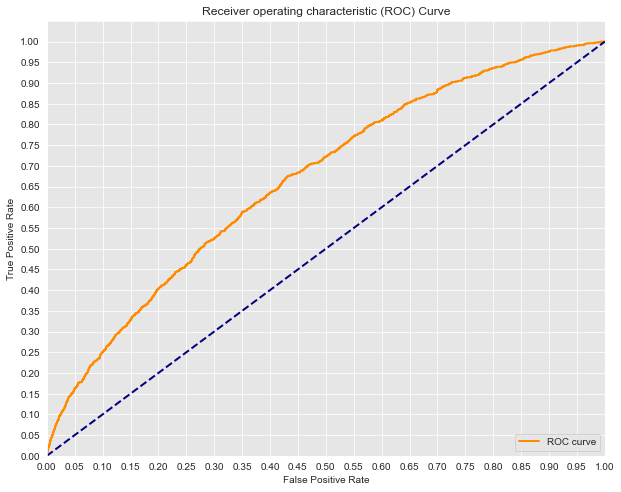

In [59]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, C=0.1, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Also tested with C=[0.01, 0.05, 0.07, 0.09, 0.1, 0.2, 0.5]   
0.1 performed best

### SMOTE oversampling for imbalance

In [61]:
#SMOTE
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

# Note, if you get an Attribute Error: 'SMOTE' object has no attribute
# '_validate_data', then downgrade your version of imblearn to 0.6.2
# or upgrade your version of sklearn to 0.23

False    3804983
True        5218
Name: n_crash, dtype: int64


False    3804983
True     3804983
Name: n_crash, dtype: int64


LogisticRegression(C=0.01, fit_intercept=False, solver='liblinear')
AUC for 0.01: 0.5866758269453134
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.5890122508130986
-------------------------------------------------------
LogisticRegression(C=0.5, fit_intercept=False, solver='liblinear')
AUC for 0.5: 0.5891888343565874
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.5892080441045389
-------------------------------------------------------


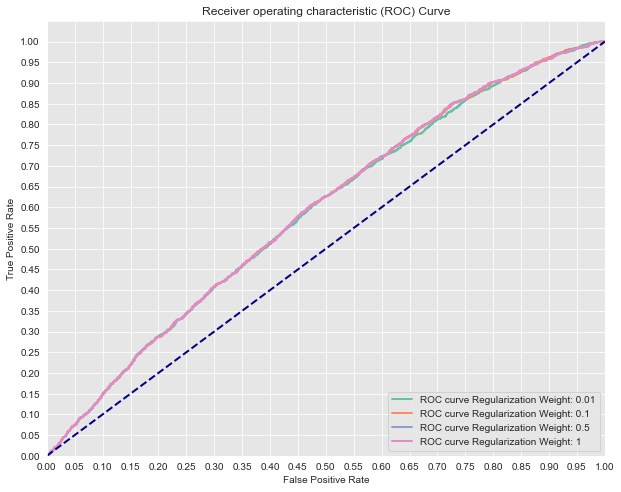

In [62]:
# SMOTE OVERSAMPLING

# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.01, 0.1, 0.5, 1]
names = [0.01, 0.1, 0.5, 1]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Best model


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


AUC: 0.6680435234257636


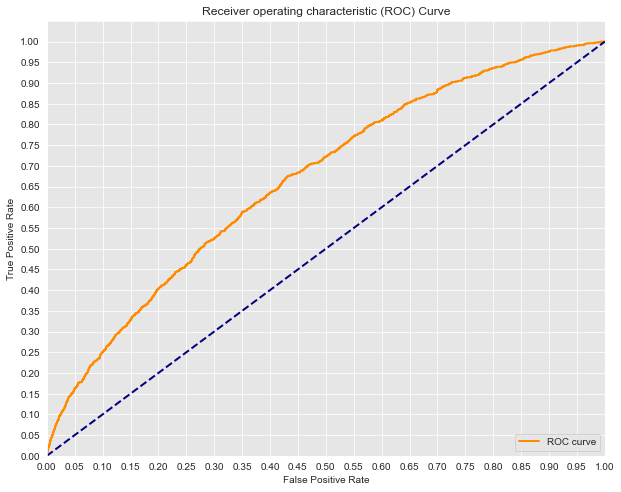

In [65]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, C=0.1, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Evaluate model

In [66]:
decisions = logreg.predict(X_test)
cm = confusion_matrix(decisions, y_test.astype(int))
#y2_test.unique()
cm

array([[951236,   1315],
       [     0,      0]])

Model is poor at prediction since there is extreme imbalance. Perhaps we can do better with probability. 

In [112]:
probs = forest.predict_proba(X)[:, 1]
probs[:5]


array([0., 0., 0., 0., 0.])

In [115]:
# let's look at a single intersection
# X_int = X[X['intersection_75TH AND STATE']==1]

# y_int = all_df[all_df['intersection']=='75TH AND STATE']['n_crash'].astype(bool).astype(int)
# y_prob = logreg.predict_proba(X_int)


print(y.sum(), probs.sum())  # this is a better approximation of actual value.


6533 6604.690000000007


## Predict daily based on probability of every intersection and hour

In [119]:
# use probabilites from above.  Now we will 
df = all_df[['year', 'month', 'day', 'hour', 'datetime', 'intersection']].copy()
df['n_crash'] = y
df['prob'] = probs

# Look at individual intersection

In [120]:
df.head()

,year,month,day,hour,datetime,intersection,n_crash,prob
0,2017,Sep,1,0,2017-09-01,111TH AND HALSTED,False,0.0
1,2017,Sep,1,0,2017-09-01,115TH AND HALSTED,False,0.0
2,2017,Sep,1,0,2017-09-01,119TH AND HALSTED,False,0.0
3,2017,Sep,1,0,2017-09-01,31ST ST AND MARTIN LUTHER KING DRIVE,False,0.0
4,2017,Sep,1,0,2017-09-01,35TH AND WESTERN,False,0.0


In [121]:
#df = df[df.intersection == '111TH AND HALSTED']

In [122]:
# group my data by hours.  Ignoring individual intersections for now.
grouped_df = df.groupby(['year', 'month', 'day']).agg({'datetime':'min', 'n_crash':'sum', 'prob':'sum'}).reset_index()

In [123]:
grouped_df.datetime

0      2017-12-01
1      2017-12-02
2      2017-12-03
3      2017-12-04
4      2017-12-05
          ...    
1259   2021-01-27
1260   2021-01-28
1261   2021-01-29
1262   2021-01-30
1263   2021-01-31
Name: datetime, Length: 1264, dtype: datetime64[ns]

In [124]:
grouped_df = grouped_df.sort_values(by='datetime')

In [145]:
import plotly.express as px


fig = px.bar(grouped_df, x='datetime', y='n_crash', width=1000, height=400) # hover_data=[]
fig.add_scatter(x=grouped_df.datetime, y=grouped_df.prob, mode='markers', name='Model Predicts')

fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="left",
                            x=0.01),
                  yaxis_title="Crashes",
                  title='Crashes by hour'
                 )

fig.update_layout(margin=dict(
                                        l=0, #left margin
                                        r=0, #right margin
                                        b=0, #bottom margin
                                        t=0  #top margin
                                        )
                    )
                    


fig.show()


In [144]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
print('R2 score {:.2f}'.format(r2_score(grouped_df['n_crash'], grouped_df['prob'])))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(grouped_df['n_crash'], grouped_df['prob']))))

R2 score 0.76
RMSE: 1.19
